<a href="https://colab.research.google.com/github/gustavoSutil/materia-IA/blob/main/deep-learn/tf/tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Estudante/Matrícula**: Gustavo Guilherme Sutil Alberton/2111100025

# Deep Learn in German Credit Numeric dataset
https://www.tensorflow.org/datasets/catalog/german_credit_numeric?hl=pt-br
https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

 ### Vou gerar um modelo capaz de classsificar proposta de crédito classicando como bons ou ruins pagadores.

 ### __Saída : 1 = Good,  2 = Bad__

 #### A documentação oficial do dataset nos tráz algumas informações importantes:

 * " É pior classificar um cliente como bom quando ele é ruim do que classificar um cliente como ruim quando ele é bom"(tradução).Ou seja mitigar falsos positivos pode ser considerado uma regra de negócio. Visto que falsos positivos, significam perdas financeiras, de reputação e de tempo.
 * A documentação nos da previamente um resumo de alguns modelos:
 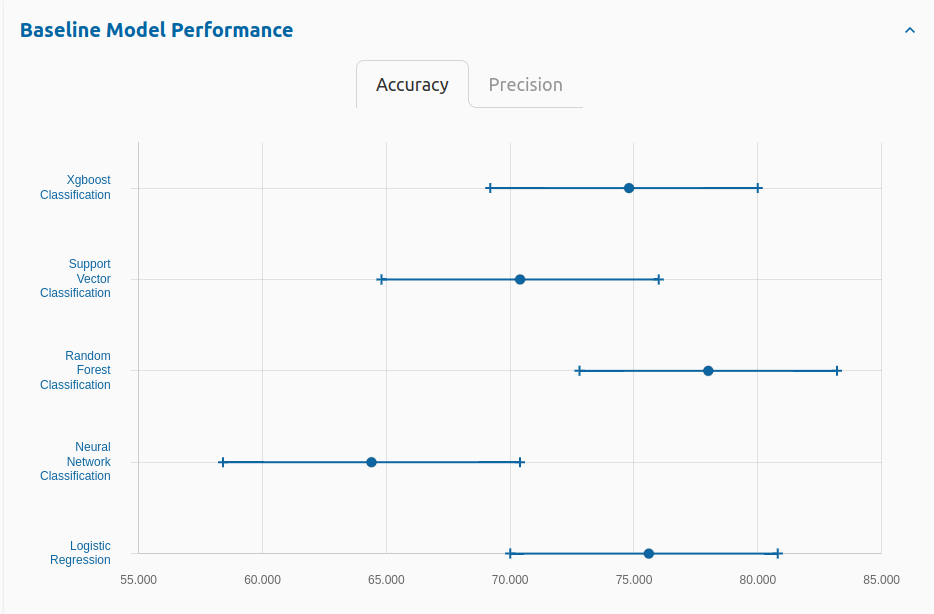

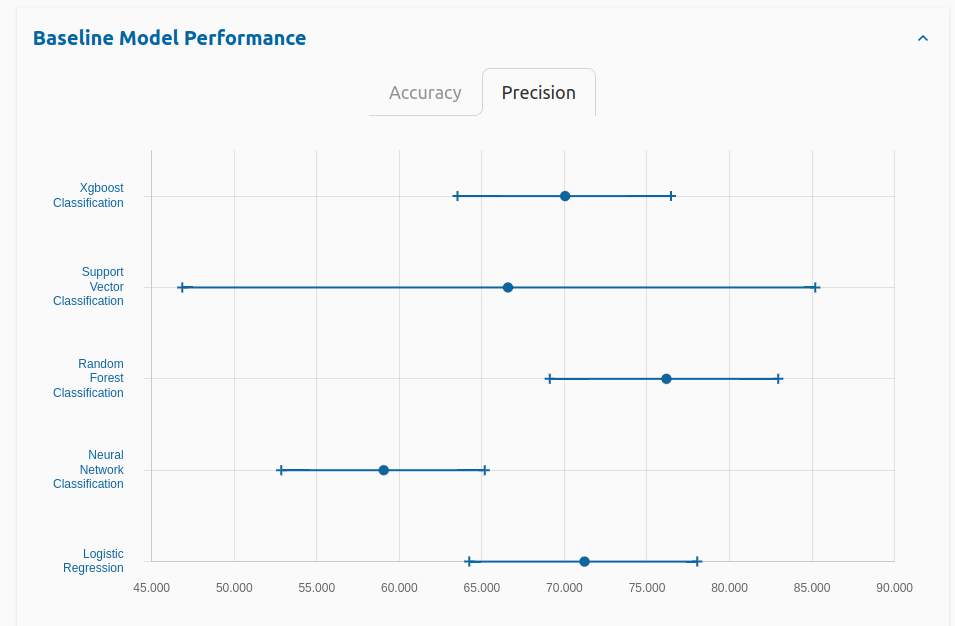

-----

### Como dito acima necessitamos de um modelo com poucos falsos positivos e isso é medido no gráfico precision, descartando assim modelos com maiores variações de precisão. Dessa forma escolho modelos baseados em florestas de decisão aleatórias. Vou também usar modelos de regressão logística como comparativo.

```
Age (numeric)
Sex (text: male, female)
Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
Housing (text: own, rent, or free)
Saving accounts (text - little, moderate, quite rich, rich)
Checking account (numeric, in DM - Deutsch Mark)
Credit amount (numeric, in DM)
Duration (numeric, in month)
Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
Risk (Value target - Good or Bad Risk)
```

Dependências

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/german_credit_data.csv",index_col=0)

In [2]:
#testando dados
print(df.head())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  


Um dos principais fatores na hora do banco emprestar dinheiro é a idade. Vamos testar esta hipotese no data-set:

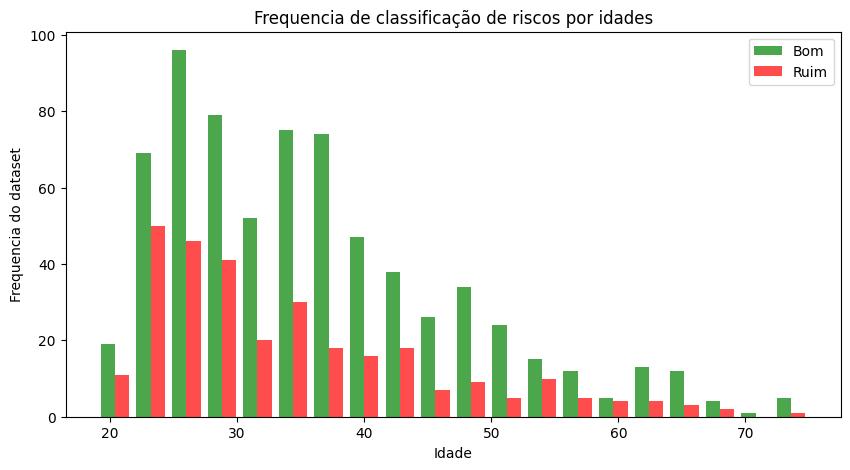

In [3]:
df_age_g = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_age_b = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

plt.figure(figsize=(10, 5))
plt.hist([df_age_g, df_age_b], bins=20, color=['green', 'red'], label=['Bom', 'Ruim'], alpha=0.7)
plt.title('Frequencia de classificação de riscos por idades')
plt.xlabel('Idade')
plt.ylabel('Frequencia do dataset')
plt.legend()
plt.show()

Quantos bons e ruins exemplos temos?

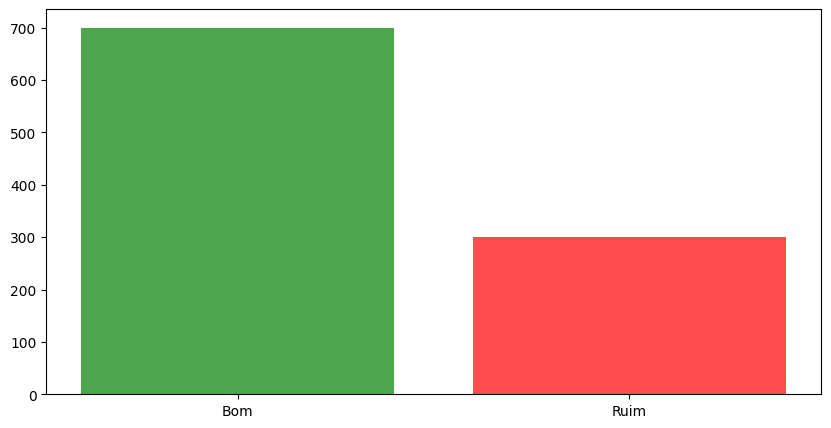

In [4]:
df_age_g_qtd = df[df["Risk"] == 'good']['Age'].count()
df_age_b_qtd = df[df["Risk"] == 'bad']['Age'].count()

plt.figure(figsize=(10, 5))
plt.bar(['Bom', 'Ruim'], [df_age_g_qtd, df_age_b_qtd], color=['green', 'red'], alpha=0.7)
plt.show()


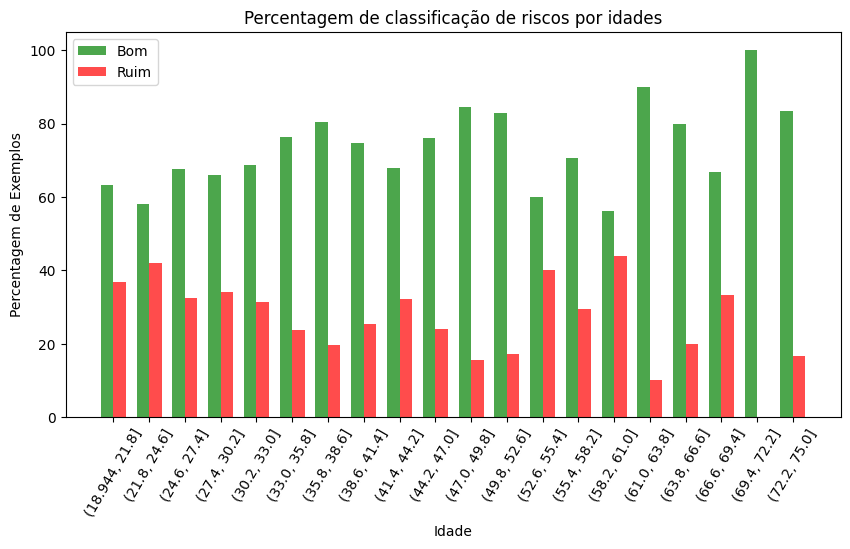

In [5]:
age_bins = 20
df['Age Bin'] = pd.cut(df['Age'], bins=age_bins)
age_counts = df['Age Bin'].value_counts().sort_index()

df_age_g_percentage = (df[df["Risk"] == 'good']['Age Bin'].value_counts() / age_counts) * 100
df_age_b_percentage = (df[df["Risk"] == 'bad']['Age Bin'].value_counts() / age_counts) * 100
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(df_age_g_percentage.index))

plt.bar(index, df_age_g_percentage, width=bar_width, color='green', label='Bom', alpha=0.7)
plt.bar([i + bar_width for i in index], df_age_b_percentage, width=bar_width, color='red', label='Ruim', alpha=0.7)

plt.xlabel('Idade')
plt.ylabel('Percentagem de Exemplos')
plt.title('Percentagem de classificação de riscos por idades')
plt.xticks([i + bar_width/2 for i in index], df_age_g_percentage.index.astype(str), rotation=60)
plt.legend()
plt.show()

O data set é muito mais complexo e para ver tentar ver a coorelação dos dados irei usar uma matriz de confusão, mas então usarei a técnica de criar dummy variables para transformar texto em numerico.

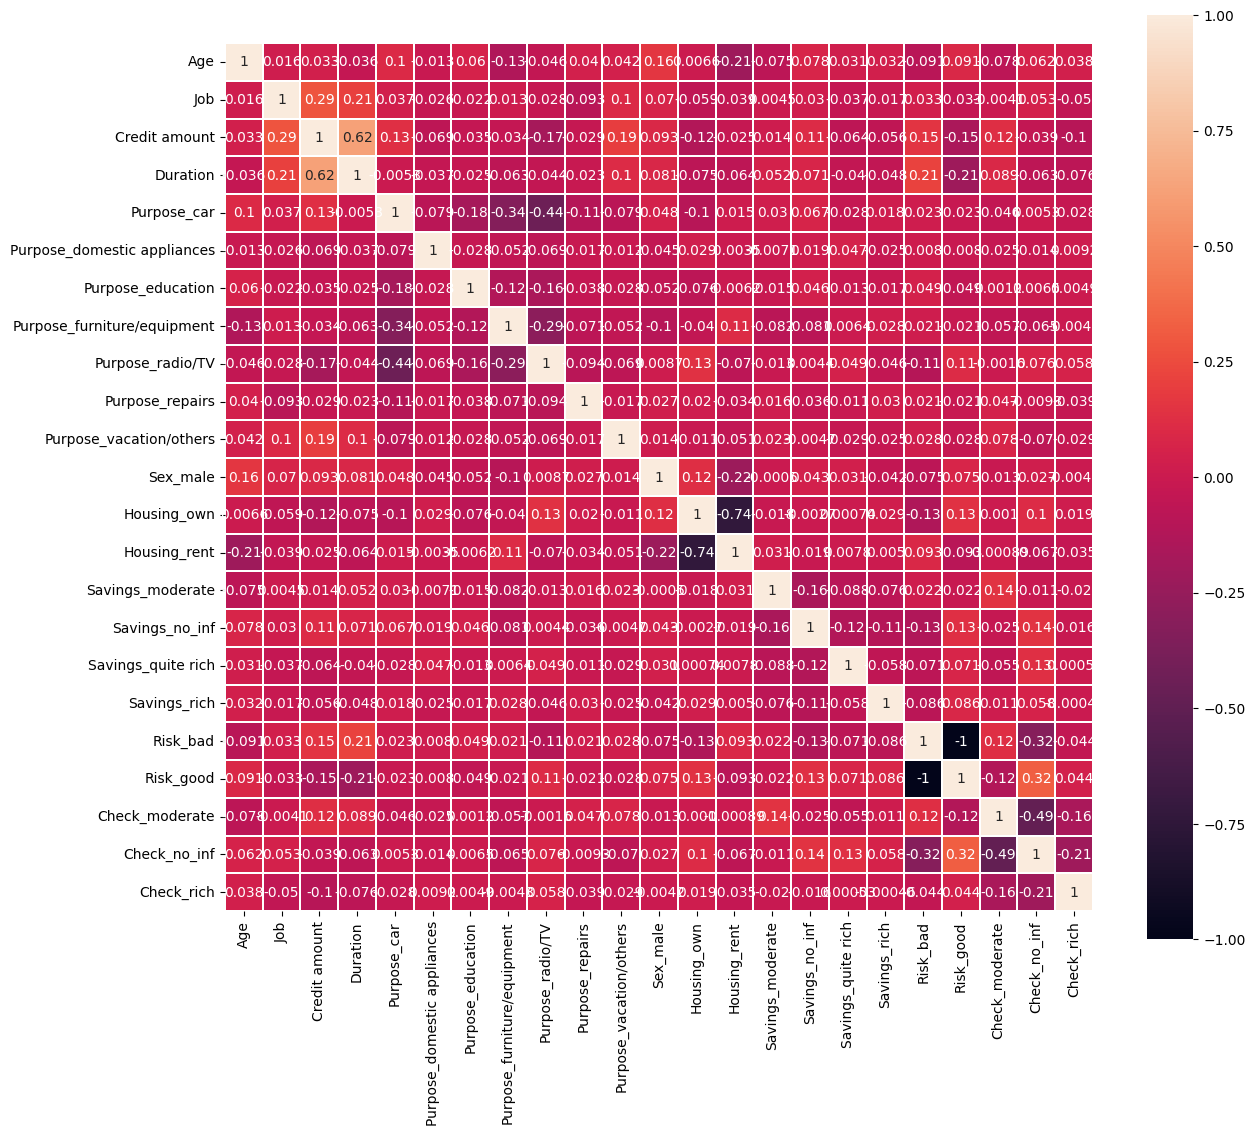

In [6]:
df_matrix = df.copy()



df_matrix['Saving accounts'] = df_matrix['Saving accounts'].fillna('no_inf')
df_matrix['Checking account'] = df_matrix['Checking account'].fillna('no_inf')
df_matrix = df_matrix.merge(pd.get_dummies(df_matrix.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
df_matrix = df_matrix.merge(pd.get_dummies(df_matrix.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
df_matrix = df_matrix.merge(pd.get_dummies(df_matrix.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
df_matrix = df_matrix.merge(pd.get_dummies(df_matrix["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
df_matrix = df_matrix.merge(pd.get_dummies(df_matrix.Risk, prefix='Risk'), left_index=True, right_index=True)
df_matrix = df_matrix.merge(pd.get_dummies(df_matrix["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
del df_matrix["Saving accounts"]
del df_matrix["Checking account"]
del df_matrix["Purpose"]
del df_matrix["Sex"]
del df_matrix["Housing"]
del df_matrix["Age Bin"]
del df_matrix["Risk"]

plt.figure(figsize=(14,12))
sns.heatmap(df_matrix.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,  linecolor='white', annot=True)
plt.show()

## Modelo 1 - florest

In [8]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import GridSearchCV

#algoritimos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [20]:
df_matrix['Credit amount'] = np.log(df_matrix['Credit amount'])

In [21]:
X = df_matrix.drop('Risk_bad', 1).values
y = df_matrix["Risk_bad"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

<ipython-input-21-5933314efe55>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_matrix.drop('Risk_bad', 1).values


In [22]:
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.889 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.867 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=1.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.978 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.739 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=1.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=5;, score=1.000 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.804 total time=   0.0s
[CV 1/5] END max_depth=3, max_feature

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [4, 7, 15, 20],
                         'n_estimators': [3, 5, 10, 25, 50, 150]},
             scoring='recall', verbose=4)

In [23]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)

rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

In [34]:
y_pred = rf.predict(X_test)

# Verificaar os resultados obtidos
print("acurácia",accuracy_score(y_test,y_pred))
print("\n")
print("matriz de confusão:\n",confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=0.5))

acurácia 1.0


matriz de confusão:
 [[178   0]
 [  0  72]]


1.0


O modelo esta muito inteligente. MEDO

In [39]:
param_grid = {"max_depth": [3,5, 7, 10],
              "n_estimators":[3,5,10,25],
              "max_features": [4,7,15]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)
rf = RandomForestClassifier(max_depth=4, max_features=10, n_estimators=15, random_state=2)

rf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.889 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.867 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=1.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.978 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.739 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=1.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=5;, score=1.000 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.804 total time=   0.0s
[CV 1/5] END max_depth=3, max_features

RandomForestClassifier(max_depth=4, max_features=10, n_estimators=15,
                       random_state=2)

In [40]:
y_pred = rf.predict(X_test)

# Verificaar os resultados obtidos
print("acurácia",accuracy_score(y_test,y_pred))
print("\n")
print("matriz de confusão:\n",confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=0.5))

acurácia 1.0


matriz de confusão:
 [[178   0]
 [  0  72]]


1.0


In [41]:
param_grid = {"max_depth": [3,5],
              "n_estimators":[3,5],
              "max_features": [4,7,15]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)
rf = RandomForestClassifier(max_depth=4, max_features=10, n_estimators=15, random_state=2)

rf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.889 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.867 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=1.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.978 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.739 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=1.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=5;, score=1.000 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.804 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=

RandomForestClassifier(max_depth=4, max_features=10, n_estimators=15,
                       random_state=2)

In [42]:
y_pred = rf.predict(X_test)

# Verificaar os resultados obtidos
print("acurácia",accuracy_score(y_test,y_pred))
print("\n")
print("matriz de confusão:\n",confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=0.5))

acurácia 1.0


matriz de confusão:
 [[178   0]
 [  0  72]]


1.0


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score

# Separando os dados em variáveis de entrada (X) e saída (y)
X = df_matrix.drop('Risk_bad', 1).values
y = df_matrix["Risk_bad"].values

# Dividindo X e y em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Definindo o espaço de parâmetros para busca de hiperparâmetros
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["l1", "l2"],
              "solver": ["liblinear"]}

# Criando o classificador de regressão logística
model = LogisticRegression(random_state=2)

# Realizando a busca de hiperparâmetros usando Grid Search Cross-Validation
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

# Criando o classificador de regressão logística com os melhores hiperparâmetros
logreg = LogisticRegression(C=grid_search.best_params_['C'],
                            penalty=grid_search.best_params_['penalty'],
                            solver=grid_search.best_params_['solver'],
                            random_state=2)

# Treinando com os melhores parâmetros
logreg.fit(X_train, y_train)

# Prevendo os resultados no conjunto de teste
y_pred = logreg.predict(X_test)

# Verificando os resultados obtidos
print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=2))


<ipython-input-44-9a8b47ebf3ef>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_matrix.drop('Risk_bad', 1).values


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.067 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.089 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.174 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.109 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.065 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.333 total time=   0.0s
[CV 2/5] END C=0

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Carregando os dados (substitua df_credit pelos seus dados)
X = df_matrix.drop('Risk_bad', 1).values
y = df_matrix["Risk_bad"].values

# Dividindo X e y em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalizando os dados (importante para redes neurais)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape dos dados para que eles sejam compatíveis com a camada Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Criando o modelo CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilando o modelo
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

# Avaliando o modelo no conjunto de teste
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Verificando os resultados obtidos
print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=2))


<ipython-input-46-e5d72666fe5d>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_matrix.drop('Risk_bad', 1).values


Epoch 1/10
19/19 - 4s - loss: 0.5035 - accuracy: 0.7467 - val_loss: 0.3770 - val_accuracy: 0.9067 - 4s/epoch - 216ms/step
Epoch 2/10
19/19 - 0s - loss: 0.2930 - accuracy: 0.9300 - val_loss: 0.1991 - val_accuracy: 0.9533 - 85ms/epoch - 4ms/step
Epoch 3/10
19/19 - 0s - loss: 0.1510 - accuracy: 0.9800 - val_loss: 0.0866 - val_accuracy: 1.0000 - 84ms/epoch - 4ms/step
Epoch 4/10
19/19 - 0s - loss: 0.0671 - accuracy: 0.9933 - val_loss: 0.0423 - val_accuracy: 1.0000 - 94ms/epoch - 5ms/step
Epoch 5/10
19/19 - 0s - loss: 0.0327 - accuracy: 0.9983 - val_loss: 0.0233 - val_accuracy: 1.0000 - 85ms/epoch - 4ms/step
Epoch 6/10
19/19 - 0s - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000 - 84ms/epoch - 4ms/step
Epoch 7/10
19/19 - 0s - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000 - 93ms/epoch - 5ms/step
Epoch 8/10
19/19 - 0s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000 - 91ms/epoch - 5ms/step
Epoch 9/10
19/19 - 0s - 

In [47]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00        72

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

